In [31]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from dlomix.losses import masked_spectral_distance, masked_pearson_correlation_distance
from dlomix.data import FragmentIonIntensityDataset

In [44]:
model_name = 'c_r_FiLM_full_d10_static_0.0005_acf.keras'

model = keras.saving.load_model('/nfs/home/students/d.lochert/projects/astral/dlomix-astral/saved_models/%s' % model_name, 
                                custom_objects={'masked_spectral_distance': masked_spectral_distance, 'masked_pearson_correlation_distance': masked_pearson_correlation_distance}, 
                                compile=True, safe_mode=True)
model.summary()

(1024, 30, 512)
(1024, 1, 5120)
Model: "transformer_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            multiple                  6656      
                                                                 
 dense_26 (Dense)            multiple                  3328      
                                                                 
 dense_27 (Dense)            multiple                  1315840   
                                                                 
 trans_block_50 (TransBlock  multiple                  524545    
 )                                                               
                                                                 
 trans_block_51 (TransBlock  multiple                  524545    
 )                                                               
                                                                 
 trans_block_52

In [34]:
int_data = FragmentIonIntensityDataset.load_from_disk("/nfs/home/students/d.lochert/projects/astral/dlomix-astral/combined_dataset")

In [56]:
tmp = [m for m in int_data.tensor_train_data.take(42)][0][0]
tmp

{'modified_sequence': <tf.Tensor: shape=(1024, 30), dtype=int64, numpy=
 array([[ 5,  7,  2, ...,  0,  0,  0],
        [20,  6, 10, ...,  0,  0,  0],
        [20, 18,  4, ...,  0,  0,  0],
        ...,
        [13,  6, 14, ...,  0,  0,  0],
        [13, 16, 14, ...,  0,  0,  0],
        [ 6, 16,  7, ...,  0,  0,  0]])>,
 'charge_oh': <tf.Tensor: shape=(1024, 6), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        ...,
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32)>,
 'collision_energy': <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0.29, 0.29, 0.3 , ..., 0.32, 0.3 , 0.28], dtype=float32)>,
 'method_nr_oh': <tf.Tensor: shape=(1024, 2), dtype=float32, numpy=
 array([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], dtype=float32)>,
 'machine_oh': <tf.Tensor: shape=(10

In [72]:
print(tmp['collision_energy'].numpy().min())
print(tmp['collision_energy'].numpy().max())

0.18
0.40184155


In [76]:
# Generate metadata combinations

charges = [
    [1,0,0,0,0,0],
    [0,1,0,0,0,0],
    [0,0,1,0,0,0],
    [0,0,0,1,0,0],
    [0,0,0,0,1,0],
    [0,0,0,0,0,1],
]
methods = [
    [1,0],
    [0,1]
]
machines = [
    [1,0,0],
    [0,1,0],
    [0,0,1]
]
energies = [x / 1000.0 for x in range(100, 500, 5)]

# Generate permutations
metadata_permutations = {
    'modified_sequence': [],
    'charge_oh': [],
    'collision_energy': [],
    'method_nr_oh': [],
    'machine_oh': [],
}
for charge in charges:
    for method in methods:
        for machine in machines:
            for energy in energies:
                metadata_permutations['charge_oh'].append(charge)
                metadata_permutations['method_nr_oh'].append(method)
                metadata_permutations['machine_oh'].append(machine)
                metadata_permutations['collision_energy'].append(energy)

for key,value in metadata_permutations.items():
    metadata_permutations[key] = np.array(value)

print(metadata_permutations)


{'modified_sequence': array([], dtype=float64), 'charge_oh': array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]]), 'collision_energy': array([0.1  , 0.101, 0.102, ..., 0.497, 0.498, 0.499]), 'method_nr_oh': array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]]), 'machine_oh': array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])}


In [79]:
# Use permutations 

res = model.get_meta_vector(metadata_permutations)
res = tf.split(res, 20, axis=-1)

In [45]:
# Use data from dataset

tmp = [m for m in int_data.tensor_train_data.take(42)][0][0]

res = model.get_meta_vector(tmp)
res = tf.split(res, 20, axis=-1)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8d40700280>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8d407003d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8d680b01f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8d680b1ba0>}

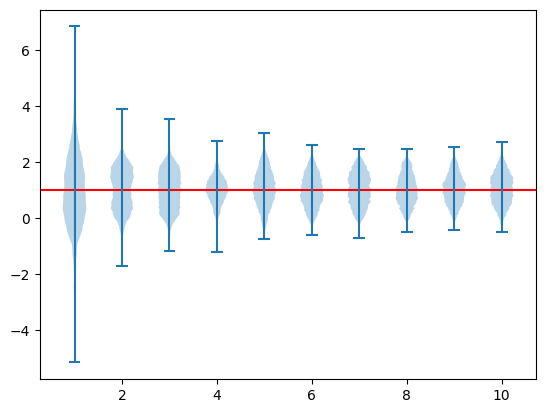

In [80]:
# Plot scaling vector
vals = [tf.reshape(res[i], [-1])+1 for i in range(0, 20, 2)]
keys = np.array([i for i in range(1, 11)])

plt.axhline(y=1, color='r', linestyle='-')
plt.violinplot(vals, keys) 

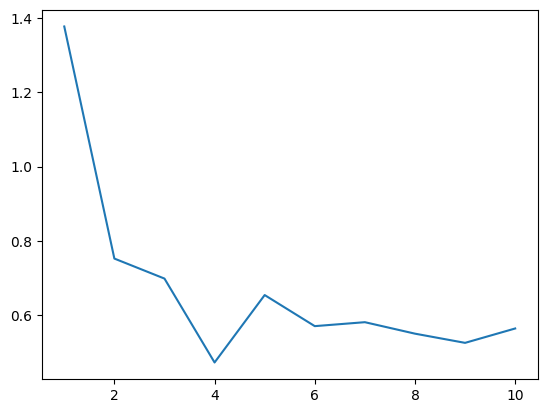

In [81]:
vals = [tf.reshape(res[i], [-1])+1 for i in range(0, 20, 2)]
keys = np.array([i for i in range(1, 11)])

std = [tf.math.reduce_std(v) for v in vals]
plt.plot(keys, std)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f8d982c0220>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f8d982c08e0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f8d982c29e0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f8d982c0be0>}

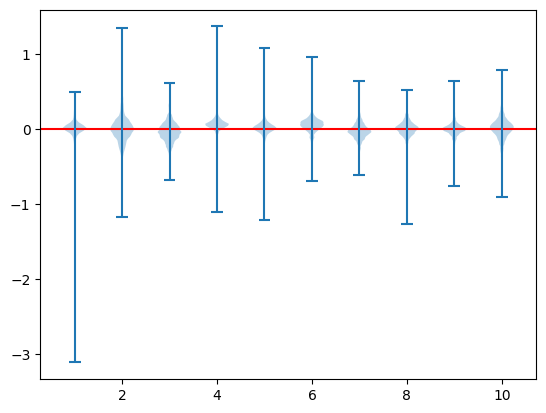

In [49]:
# Plot shift vector
vals = [tf.reshape(res[i], [-1]) for i in range(1, 20, 2)]
keys = np.array([i for i in range(1, 11)])

plt.axhline(y=0, color='r', linestyle='-')
plt.violinplot(vals, keys)

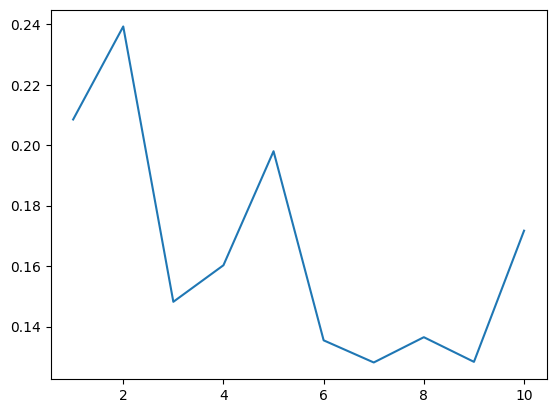

In [52]:
std = [tf.math.reduce_std(v) for v in vals]
plt.plot(keys, std)
